# Predicting airline customer future values

Classification models based on customer demographic variables and RFM variables provides useful knowledge for managers to predict future customer behavior such as how recently the customer will probably purchase, how often the customer will purchase, and what will the value of his/her purchase. 

To this puropse we use decision tree technique to track changes in RFM values of customers over time, to discover classification rules related to transition paths and thus predict the next customers’ RFM values from the current 
customers’ RFM values.

The rationale of this step is that if customers have similar demographic values, then they are very likely also to have similar RFM values. Discovering classification rules using customer demographic values is important for helping decision makers to  target customer profiles more clearly. Additionally, the effect of classification rules on recommendations should be investigated to make more effective marketing strategies.  

In [2]:
# Import libraries
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation as cv
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
import pydot
import StringIO


/usr/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/usr/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
#Load demographic and behavioral features 
df_personal = pd.read_csv("clientes_unicos.csv", sep=",", usecols= ['document_number','gender', 'fqtv_data', 'advance_purchase','age', 'cabin_code', 'distance_seg', 'pos_channel_code', 'flight_type'])

In [121]:
df_personal.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 738533 entries, 0 to 738532
Data columns (total 9 columns):
gender              738533 non-null object
age                 738533 non-null int64
document_number     738533 non-null object
fqtv_data           738533 non-null object
cabin_code          738533 non-null object
advance_purchase    738533 non-null int64
pos_channel_code    722197 non-null object
distance_seg        738533 non-null float64
flight_type         738533 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 56.3+ MB


In [4]:
# Load RFM segmentation data
df_rfm = pd.read_csv("/home/dsc/Repositories/Master-in-Data-Science/SPARK/segmentación_python.csv", sep=",", usecols=[1,2,3,4,5])

In [5]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231973 entries, 0 to 231972
Data columns (total 5 columns):
document_number    231973 non-null object
frecuencia         231973 non-null int64
recencia           231973 non-null int64
money              231973 non-null float64
cluster            231973 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 10.6+ MB


### Procress personal and behavioral data

We will categorize passengers based on: cabin_code feautre (Economy, Business or Premium), if the passanger is affliate or no in an arline loyalty program and the channel of booking

In [6]:
def Economy(cabin_code):
    if cabin_code == 'Y':
        return 'Economy'
    elif cabin_code == 'J':
        return 'Business'
    else:
        return 'Premium'

In [7]:
def getLoyalty(fqtv_data):
    if fqtv_data == " ":
        return 0
    else:
        return 1

In [8]:
def getChannel(creator_channel):
    if creator_channel == "E":
        return 'Electronic'
    elif creator_channel == "A":
        return 'Airline'
    elif creator_channel == "T":
        return 'Travel_Agency'
    else:
        return 'No-Iata'

In [9]:
df_personal['cabin_code'] = df_personal.cabin_code.apply(Economy)
df_personal['fqtv_data'] = df_personal.fqtv_data.apply(getLoyalty)
df_personal['pos_channel_code'] = df_personal.pos_channel_code.apply(getChannel)
df_personal.head()

,gender,age,document_number,fqtv_data,cabin_code,advance_purchase,pos_channel_code,distance_seg,flight_type
0,F,70,91278FT46,1,Economy,107,Airline,1945.217146,I
1,F,70,91278FT46,1,Economy,113,Airline,2230.883963,I
2,F,63,91278FT66,1,Economy,16,Airline,1945.217146,I
3,F,63,91278FT66,1,Economy,22,Airline,2230.883963,I
4,F,71,91280BO32,1,Economy,14,Airline,8320.719233,I


In [10]:
# Merge personal and behavioral features and RFM variables based on document number us as primary key
df_merged = pd.merge(df_personal, df_rfm, on = 'document_number')

### Data visualization

We explore the relationship between segment classification and personal and behavioral characteristics of the passangers

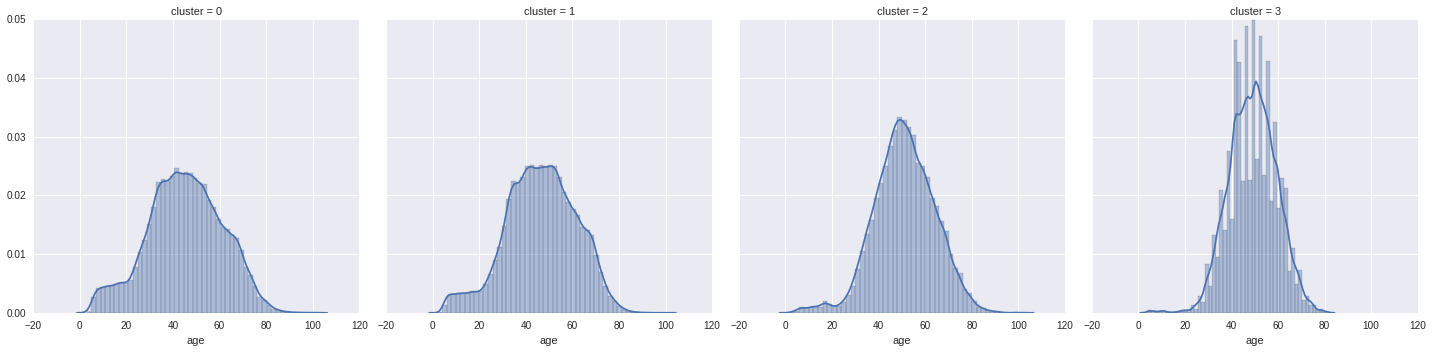

In [129]:
#Age distribution for Cluster
g= sns.FacetGrid(df_merged, col="cluster", col_wrap=4, size=5)
g.map(sns.distplot,"age" )


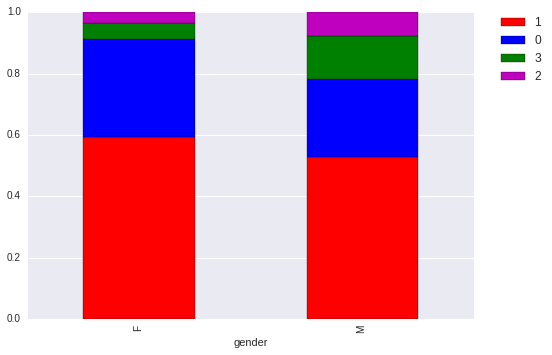

In [11]:
#Gender distribution for Cluster
a=df_merged.groupby('gender').cluster.value_counts()/df_merged.groupby('gender').cluster.count()
a.unstack().plot(kind='bar',stacked=True,color=['r','b', 'g', 'm'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)

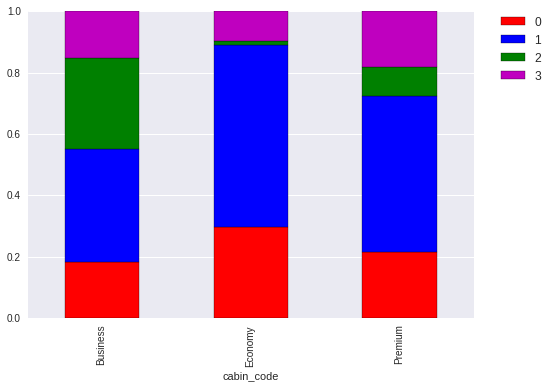

In [12]:
#Costumer type distribution for Cluster
a=df_merged.groupby('cabin_code').cluster.value_counts()/df_merged.groupby('cabin_code').cluster.count()
a.unstack().plot(kind='bar',stacked=True,color=['r','b', 'g', 'm'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)

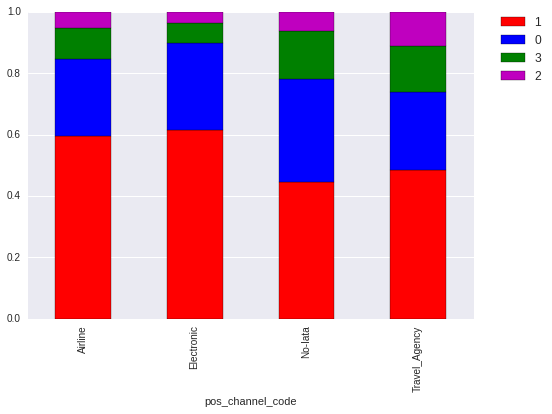

In [13]:
#Booking channel distribution for Cluster
a=df_merged.groupby('pos_channel_code').cluster.value_counts()/df_merged.groupby('pos_channel_code').cluster.count()
a.unstack().plot(kind='bar',stacked=True,color=['r','b', 'g', 'm'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)

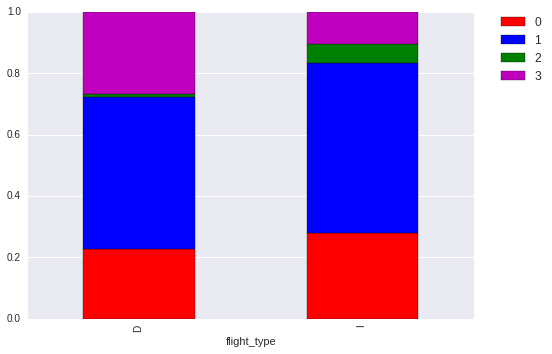

In [14]:
#FLight type distribution for Cluster

a=df_merged.groupby('flight_type').cluster.value_counts()/df_merged.groupby('flight_type').cluster.count()
a.unstack().plot(kind='bar',stacked=True,color=['r','b', 'g', 'm'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)

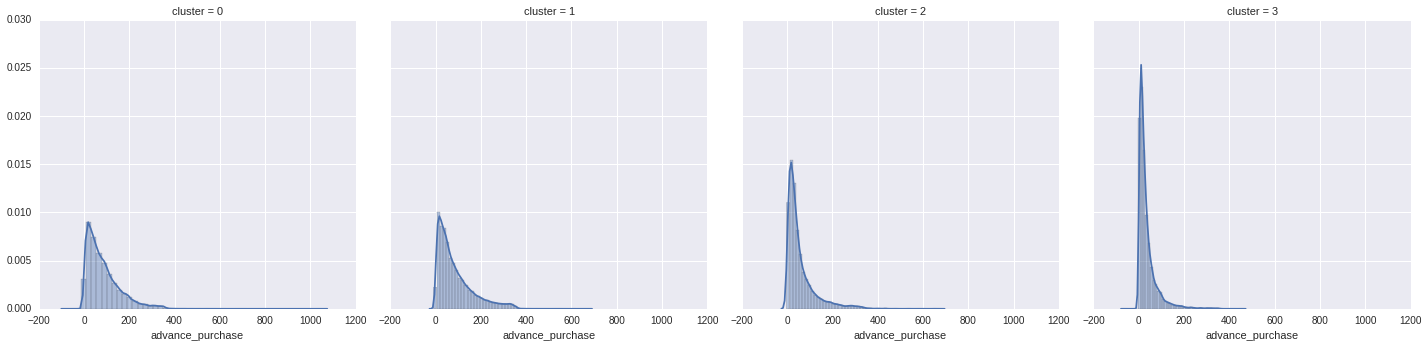

In [15]:
#Advance purchase distribution for Cluster
g= sns.FacetGrid(df_merged, col="cluster", col_wrap=4, size=5)
g.map(sns.distplot,"advance_purchase" )



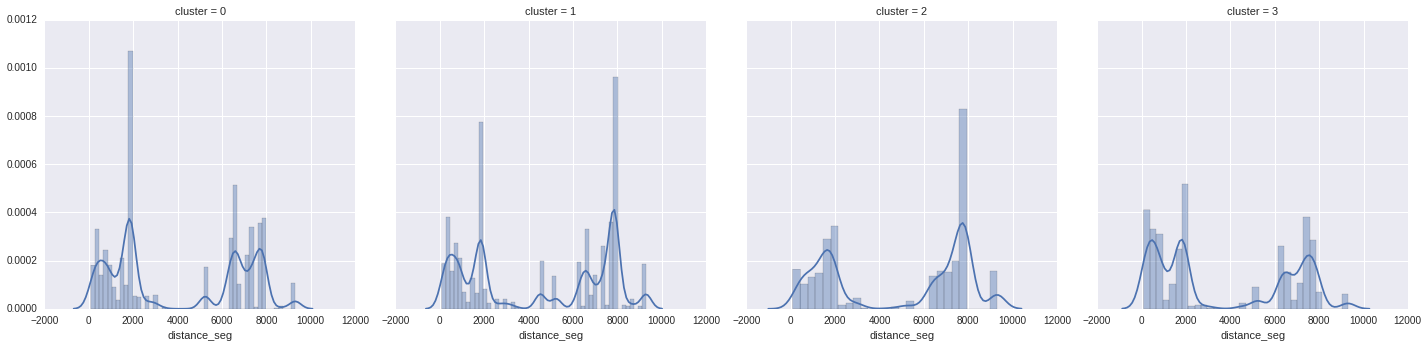

In [16]:
#Distance distribution for Cluster
g= sns.FacetGrid(df_merged, col="cluster", col_wrap=4, size=5)
g.map(sns.distplot,"distance_seg" )


### Feature engineering

We deal with categorial data using dummy variables

In [11]:
# We deal with categorical data using dummy variables
dummies_Gender=pd.get_dummies(df_personal['gender'],prefix='Sex')
dummies_Pclass=pd.get_dummies(df_personal['cabin_code'],prefix='Pclass')
dummies_channel = pd.get_dummies(df_personal.pos_channel_code, prefix= 'Channel')
dummies_flight= pd.get_dummies(df_personal.flight_type, prefix = "Flight")
df_personal = pd.concat([df_personal, dummies_Gender, dummies_Pclass, dummies_channel, dummies_flight], axis=1)
df_personal = df_personal.drop(['gender','cabin_code', 'pos_channel_code', 'flight_type'], axis=1)
df_personal.head()

,age,document_number,fqtv_data,advance_purchase,distance_seg,Sex_F,Sex_M,Pclass_Business,Pclass_Economy,Pclass_Premium,Channel_Airline,Channel_Electronic,Channel_No-Iata,Channel_Travel_Agency,Flight_D,Flight_I
0,70,91278FT46,1,107,1945.217146,1,0,0,1,0,1,0,0,0,0,1
1,70,91278FT46,1,113,2230.883963,1,0,0,1,0,1,0,0,0,0,1
2,63,91278FT66,1,16,1945.217146,1,0,0,1,0,1,0,0,0,0,1
3,63,91278FT66,1,22,2230.883963,1,0,0,1,0,1,0,0,0,0,1
4,71,91280BO32,1,14,8320.719233,1,0,0,1,0,1,0,0,0,0,1


In order to have the same number of rows in personal (738533) and RFM (231973) data frames we have to group each sample of the personal data frame by document_number and then aggregate the variables to have one row per passanger

In [12]:
df_personal = df_personal.groupby(['document_number']).agg({ 'age': lambda x: x.mean(),
                                            'advance_purchase': lambda x: x.mean(),
                                            'distance_seg': lambda x: x.mean(),          
                                            'Sex_F': lambda x: x.max(),# First
                                            'Sex_M': lambda x: x.max(),
                                            'Pclass_Business': lambda x: x.max(),
                                            'Pclass_Economy': lambda x: x.max(),
                                            'Pclass_Premium': lambda x: x.max(),         
                                            'Channel_Airline': lambda x: x.max(),
                                            'Channel_Electronic': lambda x: x.max(),         
                                            'Channel_No-Iata': lambda x: x.max(),          
                                            'Channel_Travel_Agency': lambda x: x.max(),         
                                            'Flight_D': lambda x: x.max(),        
                                            'Flight_I': lambda x: x.max(),       
                                            'fqtv_data': lambda x: x.max()})       
                                                    
                                                  

In [13]:
len(df_personal)

231974

In [14]:
# We set de document number as index
df_rfm.groupby(['document_number'])
df_rfm = df_rfm.set_index("document_number")

In [15]:
# We join both data frames using document number as primary key
df = pd.concat([df_personal, df_rfm], axis=1, join='outer', join_axes=[df_rfm.index], ignore_index=False,
       keys=None, levels=None, names=None, verify_integrity=False)

In [16]:
df.head()

,Channel_No-Iata,distance_seg,Pclass_Business,Channel_Electronic,Channel_Travel_Agency,Sex_F,Channel_Airline,Sex_M,fqtv_data,Flight_D,age,Pclass_Economy,Pclass_Premium,advance_purchase,Flight_I,frecuencia,recencia,money,cluster
document_number,,,,,,,,,,,,,,,,,,,
000005678,0,5393.079133,1,0,1,1,0,0,1,0,67,0,0,65.0,1,1,180,2900.00,2
00000BS96,1,6610.159533,0,0,0,0,0,1,1,0,62,1,0,154.5,1,1,2,263.00,1
00000S942,0,3362.317694,0,1,0,1,0,0,1,0,26,1,0,99.0,1,1,217,212.96,0
00001BG93,0,6610.159533,0,1,0,1,0,0,1,0,48,1,0,60.0,1,1,33,315.44,1
00002926,0,4018.582748,1,0,1,0,0,1,1,0,44,1,0,13.0,1,2,23,2577.22,1


In [17]:
len(df)

231973

### Selecting features

In this section we select independet variables and dependet variable. We split the sample in training and test and we normalize independent variables

In [18]:
features = [ 'age', 'fqtv_data', 'advance_purchase', 'distance_seg', 'Sex_F', 'Sex_M', 'Pclass_Business', 'Flight_I', 'Flight_D', 'Pclass_Economy', 'Pclass_Premium', 'Channel_Airline', 'Channel_Electronic', 'Channel_No-Iata', 'Channel_Travel_Agency']

In [19]:
def getsegmentos(l):
    if l < 401:
        return 1
    elif 400<l<701:
        return 2
    else:
        return 3

In [20]:
df['cluster'] = df['money'].map(getsegmentos)



In [21]:
variables = df[features]
X = sklearn.preprocessing.normalize(variables, norm='l2', axis=0, copy=True)
y = df.cluster
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)



###  Modeling and Validation

We obtain satisfying results in predicting customer value using decision trees, which have some important advantages  over  other  methods,  including  high  flexibility  and  ability  to handle  categorical  variables.  Particularly  interesting  for  practical  implementation  is  the identification of workable rules that allow managers to easily 
classify customers according to their attributes and thus implement profit maximising marketing strategies.  

We run two types of decision tree models to predict passanger values. We have chosen Random Forest and Decision Tree model to compare their performance on well classifying airline customers. 

Analyzing the different parameters of Decision Tree Model.


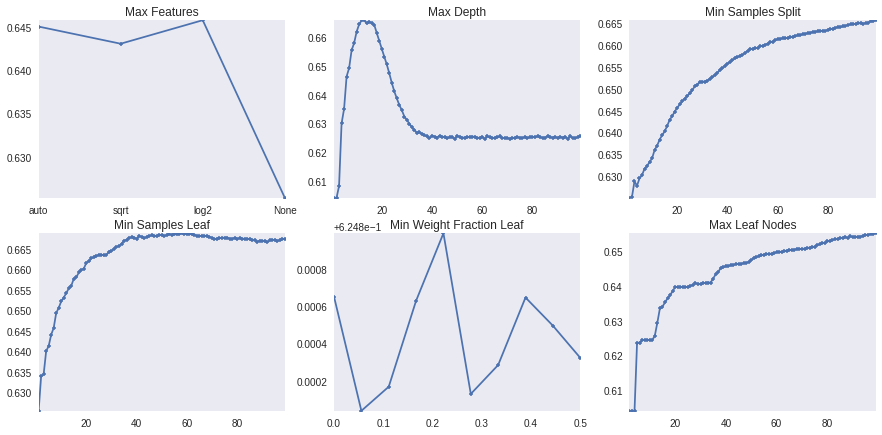

In [110]:
plt.figure(figsize=(15,7))

#Max Features
plt.subplot(2,3,1)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(2,3,3)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Samples Leaf
plt.subplot(2,3,4)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Leaf')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(2,3,6)
feature_param = range(2,100)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();


After examing graphics we select the values to each model parameter

In [22]:
from sklearn.externals.six import StringIO  
import pydot
from sklearn import tree
from IPython.display import Image  

ctr = tree.DecisionTreeClassifier(criterion='gini', 
                             max_depth=20, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=None, 
                             max_leaf_nodes=10, 
                             class_weight=None) 

ctr_ = ctr.fit(X_train, y_train)

We examine the accuracy of decision tree model with a confusion matrix

[[ 0.78497166  0.03653806  0.17849028]
 [ 0.57790243  0.20427329  0.21782428]
 [ 0.32842536  0.06923751  0.60233713]]


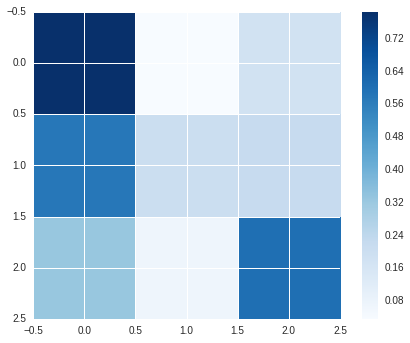

In [23]:
from sklearn.metrics import confusion_matrix
ctr_ = ctr.fit(X_train, y_train)
predictarr = ctr.predict(X_test)
trutharr = y_test.values
cm = confusion_matrix(trutharr, predictarr)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

confusion = np.matrix(cm_normalized)
print (cm_normalized)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

We plot the feature importance resulting from Decision Tree Classifier

Feature ranking:
1. feature 6 (0.362384)
2. feature 3 (0.354417)
3. feature 11 (0.102327)
4. feature 2 (0.102279)
5. feature 12 (0.051752)
6. feature 9 (0.026842)
7. feature 14 (0.000000)
8. feature 13 (0.000000)
9. feature 10 (0.000000)
10. feature 8 (0.000000)
11. feature 7 (0.000000)
12. feature 5 (0.000000)
13. feature 4 (0.000000)
14. feature 1 (0.000000)
15. feature 0 (0.000000)


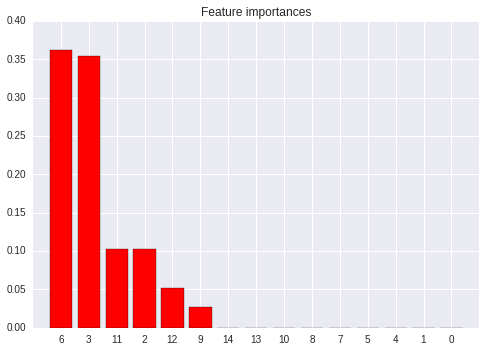

Features sorted by their score:
[(0.3624, 'Pclass_Business'), (0.3544, 'distance_seg'), (0.1023, 'advance_purchase'), (0.1023, 'Channel_Airline'), (0.0518, 'Channel_Electronic'), (0.0268, 'Pclass_Economy'), (0.0, 'fqtv_data'), (0.0, 'age'), (0.0, 'Sex_M'), (0.0, 'Sex_F'), (0.0, 'Pclass_Premium'), (0.0, 'Flight_I'), (0.0, 'Flight_D'), (0.0, 'Channel_Travel_Agency'), (0.0, 'Channel_No-Iata')]


In [28]:
importances = ctr.feature_importances_
names = variables.columns
std = np.std([ctr.feature_importances_ for tree in names],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), importances), names), 
             reverse=True)

We can export the in tree using the export_graphviz exporter. Graphviz format also supports a variety of aesthetic options, including coloring nodes by their class (or value for regression) and using explicit variable and class names if desired. We render the plot of decsion tree inline using the Image() function:

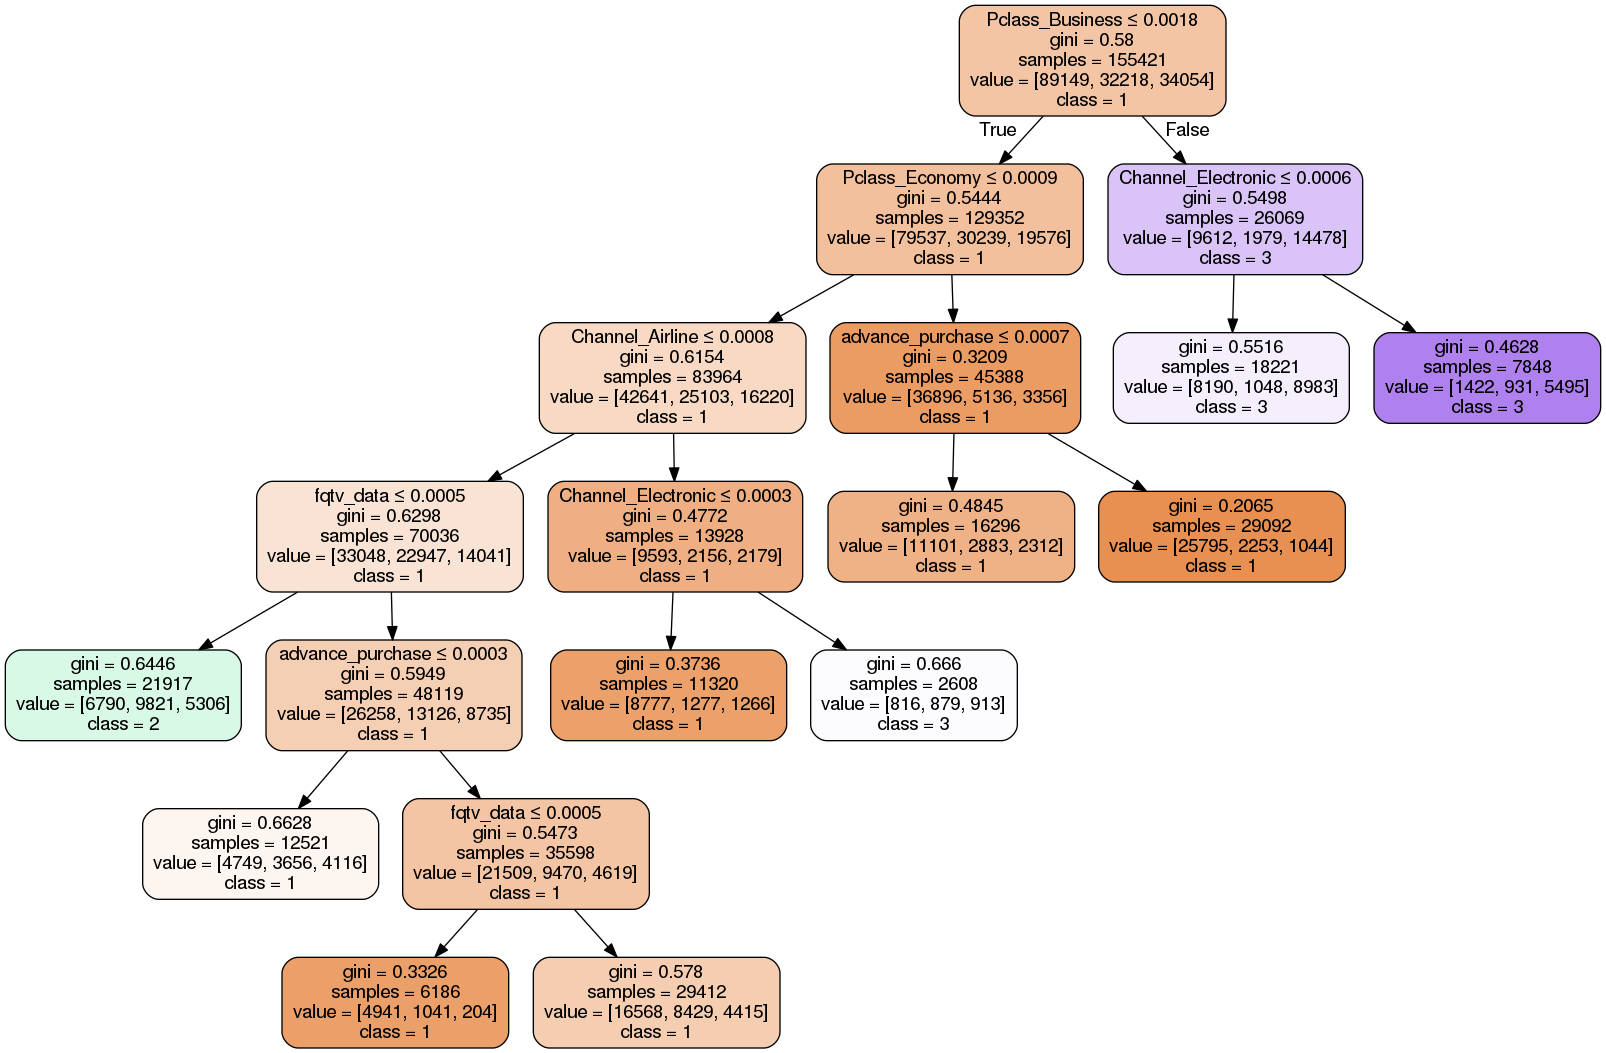

In [106]:
from IPython.display import Image  
dot_data = StringIO()  
tree.export_graphviz(ctr, out_file=dot_data,  
                         feature_names= variables.columns,  
                         class_names= ctr_.classes_.astype(int).astype(str),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

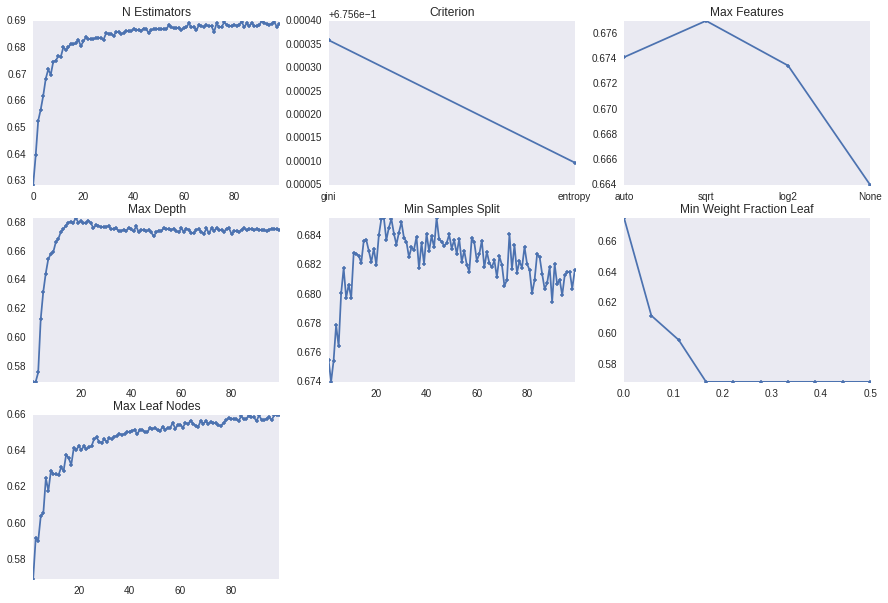

In [109]:
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('N Estimators')
plt.grid();

#Criterion
plt.subplot(3,3,2)
feature_param = ['gini','entropy']
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Criterion')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(1,100)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,100)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

After analyzing the different graphics, we select the values to each model parameter

In [34]:

clf = RandomForestClassifier(n_estimators=100, 
                             criterion='gini', 
                             max_depth=20, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=None, 
                             max_leaf_nodes=9, 
                             class_weight=None)                         
                  



 We examine the accuracy of random forest model with a confusion matrix

[[ 0.84758211  0.03653806  0.11587983]
 [ 0.73055591  0.20427329  0.06517081]
 [ 0.49494595  0.06923751  0.43581654]]


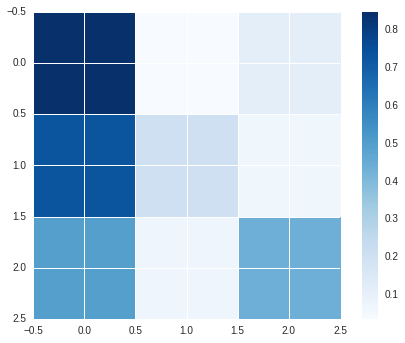

In [35]:
from sklearn.metrics import confusion_matrix
clf = clf.fit(X_train, y_train)
predictarr = clf.predict(X_test)
trutharr = y_test.values
cm = confusion_matrix(trutharr, predictarr)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

confusion = np.matrix(cm_normalized)
print (cm_normalized)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()



We plot the contribution of features to classify airline customers 

Feature ranking:
1. feature 6 (0.372688)
2. feature 3 (0.366500)
3. feature 2 (0.105157)
4. feature 11 (0.078175)
5. feature 12 (0.054015)
6. feature 9 (0.023465)
7. feature 14 (0.000000)
8. feature 13 (0.000000)
9. feature 10 (0.000000)
10. feature 8 (0.000000)
11. feature 7 (0.000000)
12. feature 5 (0.000000)
13. feature 4 (0.000000)
14. feature 1 (0.000000)
15. feature 0 (0.000000)


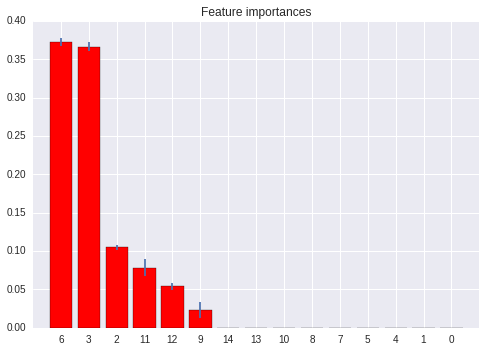

Features sorted by their score:
[(0.3727, 'Pclass_Business'), (0.3665, 'distance_seg'), (0.1052, 'advance_purchase'), (0.0782, 'Channel_Airline'), (0.054, 'Channel_Electronic'), (0.0235, 'Pclass_Economy'), (0.0, 'fqtv_data'), (0.0, 'age'), (0.0, 'Sex_M'), (0.0, 'Sex_F'), (0.0, 'Pclass_Premium'), (0.0, 'Flight_I'), (0.0, 'Flight_D'), (0.0, 'Channel_Travel_Agency'), (0.0, 'Channel_No-Iata')]


In [36]:

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
names = variables.columns
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), importances), names), 
             reverse=True)